# Exploring covariance between properties across scales
**Authors**: Benjamin Jasperson, Harley T. Johnson

**GitHub URL**: https://github.com/bjasperson/property-covariance-demo

# Background Information

This workbook explores the use of interatomic potential (IP)-generated data to uncover correlations between fundamental microscopic properties, which we call canonical properties, and large-scale quantities of interest (QoI).
It closely follows the work outlined in [this manuscript](https://doi.org/10.1016/j.actamat.2025.120722).

As a proof-of-principle, we'll use grain boundary (GB) energy as our QoI. 
Specifically, we'll look at how canonical properties relate to the scaling factor in the universal lattice matching (LM) model of Runnels et al. (2016).
You don't need to worry about how this coefficient is defined; see the paper for details. Just think of it as a scalar measure of grain boundary energy.

By the end of this workbook, you will have:
1. Explored a dataset of IP-generated property results, uncovering correlations that can be used in a multiscale regression model.
2. Developed a regression model using canonical properties identified through k-fold cross-validation.
3. Used the regression model with first-principles indicator properties to make a prediction for the GB scaling coefficient from first-principles canonical properties.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm

from itertools import combinations
from textwrap import wrap

# Download Data
To begin, we need to import our project data. The data we will use is originally from [this manuscript](https://arxiv.org/abs/2411.16770) ([published here](https://doi.org/10.1016/j.actamat.2025.120722)). You can find the original paper repo [here](https://github.com/Johnson-Research-Group/gb_covariance).

The data includes IP-generated canonical properties, along with an LM model scaling factor calculated from individual symmetric-tilt GB energy simulations.

**Task**: Using pandas, download the CSV file with this [link](https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true), save the dataframe as `df_data`, and look at the first five rows.

In [3]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true"
df_data = pd.read_csv(url_link, index_col=0)
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_fcc,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,1.383830,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,0.841906,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,0.746775,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295


# Data review
It is important to get a feel for the data that you are working with. To make plotting a little nicer, we have a csv file with key/value pairs to convert the variable names into human readable format.  

**Task**: import the label csv file, located at `./data/label_dict.csv`, and convert it to a dictionary called `label_dict` using pandas, for use with plotting.

In [4]:
def import_label_dict(label_dict_path = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/label_dict.csv?raw=true"):
    """import the ./data/label_dict.csv file, convert it to a dictionary

    Args:
        label_dict_path (str, optional): path to csv file with key/value pairs.

    Returns:
        dict: a dictionary with df column names as keys, and human-readable label as value
    """
    
    # useful for plotting purposes
    df_label_dict = pd.read_csv(label_dict_path)
    label_dict = df_label_dict.to_dict(orient="records")[0]
    return label_dict

label_dict = import_label_dict()

Now, let's write a function that calculates the [correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between two variables. 

**Task**: given our dataframe, create a function that uses [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate the correlation coefficient between each set of variables. First, make a copy of the dataframe and replace the column names with the human readable version from the label dictionary using list comprehension. Next, apply the `corr` method to the copied dataframe to create `df_corr`. Finally, sort both the columns *and* rows of `df_corr` based on how correlated the variable is to the scaling factor, `$E_0$`.

In [22]:
def correlation_df(df, label_dict):
    """create df with correlation values

    Args:
        df (pandas.DataFrame): property data (columns) for a given IP (row) 
        label_dict (dict): the label dict from above, to convert label keys to human readable format

    Returns:
        pandas.DataFrame: correlation coefficient between canonical properties and coeff ($E_0$). Sort both the columns and rows by how correlated they are with the coeff $E_0$.
    """
    df_in = df.copy()
    df_in.columns = [label_dict[x] for x in df_in.columns]
    df_corr = df_in.corr().round(2)

    order = df_corr['$E_0$'].sort_values(ascending=False).index.to_list()
    df_corr = df_corr[order].reindex(order)
    return df_corr

We now want to look at how the different fundamental properties relate with each other and our Quantity of Interest (GB energy coefficient). To aid in this, we will look at two plots.

First, let's plot a heat map of the correlation coefficient. 

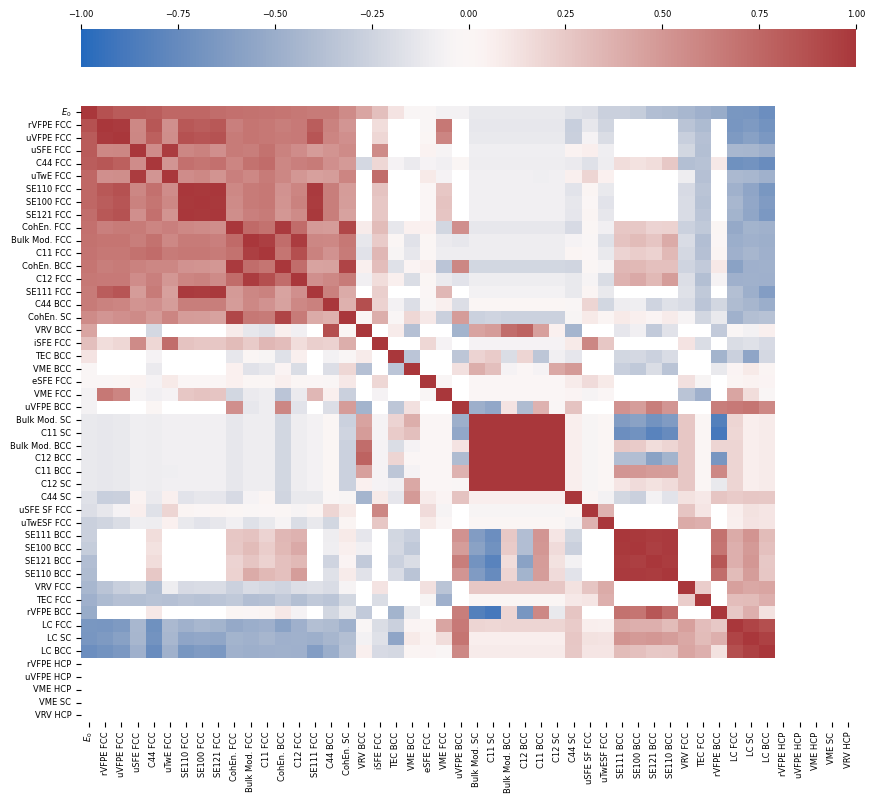

In [6]:
def corr_plot(df, 
              label_list, 
              label_dict, 
              annot = False, 
              figsize = (10,10),
              annotation_fontsize = 6,
              tick_fontsize = 6,
              ):
    
    df_corr = correlation_df(df[label_list], label_dict)
    fig,ax = plt.subplots(figsize = (figsize[0],figsize[1]))
    colors = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(df_corr, vmin = -1, vmax = 1, cmap=colors,
                annot=annot,
                xticklabels=True,
                yticklabels=True,
                fmt = '.1f',
                annot_kws = {"fontsize":annotation_fontsize},
                cbar_kws = {"location":"top"}
                )
    ax.tick_params(labelsize=tick_fontsize)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=tick_fontsize)

label_list = df_data.columns.to_list()#["coeff", "lattice_constant_fcc", "lattice_constant_bcc", "c11_fcc", "c12_fcc", "c44_fcc", 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc']
label_list.remove("crystal_type")
label_list.remove("species")
label_list.remove("model")
corr_plot(df_data, label_list, label_dict)

Next, let's look at pairplots of the most correlated features. 

**Task**: create a function to plot a set of properties from the property dataframe. Use Seaborn pairplot, and set the marker color (`hue`) based on `species`. Explore different combinations of pairplots for the data.

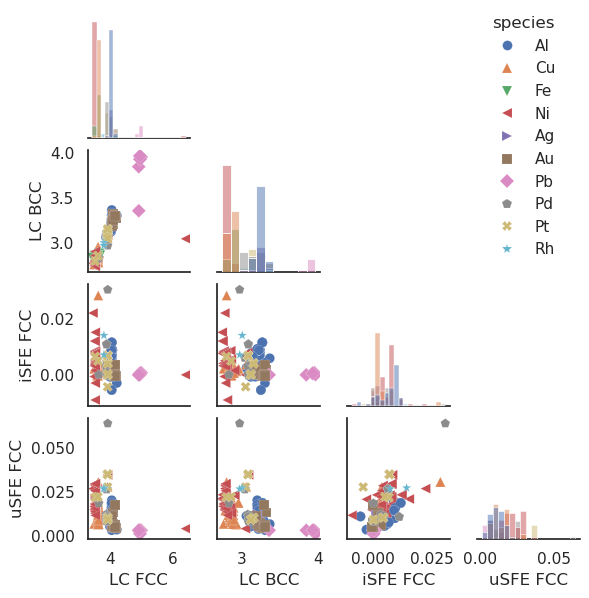

In [7]:
def pairplot_fun(df, 
                 params_list,  
                 label_dict, 
                 height=1.5,
                 ):
    """create pairplot for select indicator properties

    Args:
        df (pandas.DataFrame): dataframe of data that was previously imported
        params_list (list): list of parameter strings to use
        label_dict (dict): the label dict from above, to convert label keys to human readable format
        height (float): pairplot height. Defaults to 2.0.
        xlims (list): list of limits to use for plotting
    """
    if 'species' not in params_list:
        params_list.extend(['species'])
    X = df[params_list]
    X.columns = [label_dict[x] for x in X.columns.to_list()]
    sns.set_theme(style="white", font_scale = 1)
    marker_list = ['o','^','v','<','>','s','D','p','X','*','.','P']
    g = sns.pairplot(X, hue='species', corner=True, markers = marker_list[0:len(df.species.drop_duplicates())],
                     plot_kws=dict(s=50, linewidth=0.1, rasterized = True), 
                     height=height,
                     diag_kind='hist')
    sns.move_legend(g, "upper right", bbox_to_anchor = (0.85,1))

plot_param_list = ["lattice_constant_fcc", "lattice_constant_bcc", 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc']
pairplot_fun(df_data, plot_param_list, label_dict)

Some questions to ponder:
1. Did you find factors that you think are worth including?
2. Do you see any outliers that we need to remove? How will you decide what is an outlier?

# Identifying indicator properties

Now that we have our data, we want to figure out which canonical properties will be best for our model. To do that, we'll use a [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) with [k-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold).

## Develop regression model

**Task**: Write a function that returns a linear regression pipeline. Your pipeline should include the following steps:
- StandardScaler: for scaling the input values; helpful for SVR, used in LR for consistency. 
- KNNImputer: for filling in the missing property values in our data. Set `n_neighbors=2` and `keep_empty_features=True`
- LinearRegression: the linear regression model (`linear_model.LinearRegression()`).

Combine these in a `Pipeline` to facilitate easy use .

In [23]:
def linear_regr_pipeline():
    """creates a linear regression pipeline for modeling purposes

    Returns:
        sklearn.pipeline.Pipeline: linear regression pipeline
    """

    # Linear regression selection pipeline, used in manuscript
    imput = KNNImputer(n_neighbors=2,
                       keep_empty_features=True)
    model = linear_model.LinearRegression()

    pipe = Pipeline(steps=[('scale', StandardScaler()),
                            ('imp', imput),
                            ('lr', model)])
    return pipe

pipe = linear_regr_pipeline()

Now, we need to make a list of the properties we are interested in considering as indicator properties for our model. A starting point is provided below.

**If time**: explore different properties, and see if any new additions result in improved models!

In [9]:
# list of parameters to explore
params_list = ['lattice_constant_fcc',
                'bulk_modulus_fcc', 'c11_fcc', 'c12_fcc', 'c44_fcc',
                'extr_stack_fault_energy_fcc', 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc'
                ]

Using the parameter list, we want to make a list of possible combinations up to a certain number of factors. 

**Task**: write a function that uses the `combinations` function from `itertools` to make a list of lists, with possible combinations of factors up to `n_factor_max`.

In [24]:
def create_subsets_list(factor_list, n_factor_max):
    """create all possible combinations of factors from a list, up to n_factor_max

    Args:
        factor_list (list): a list of individual factors (str) to consider
        n_factor_max (int): maximum number of factors to consider in one model

    Returns:
        list: a list of lists, with each sub-list containing the factors (str) to include (e.g., ['c11_fcc', 'c12_fcc'])
    """
    subsets = []
    for n in range(1, (n_factor_max+1)):
        for subset in combinations(factor_list, n):
            subsets.append(list(subset))
    return subsets

subsets = create_subsets_list(params_list, n_factor_max = 2)
print(subsets)

[['lattice_constant_fcc'], ['bulk_modulus_fcc'], ['c11_fcc'], ['c12_fcc'], ['c44_fcc'], ['extr_stack_fault_energy_fcc'], ['intr_stack_fault_energy_fcc'], ['unstable_stack_energy_fcc'], ['lattice_constant_fcc', 'bulk_modulus_fcc'], ['lattice_constant_fcc', 'c11_fcc'], ['lattice_constant_fcc', 'c12_fcc'], ['lattice_constant_fcc', 'c44_fcc'], ['lattice_constant_fcc', 'extr_stack_fault_energy_fcc'], ['lattice_constant_fcc', 'intr_stack_fault_energy_fcc'], ['lattice_constant_fcc', 'unstable_stack_energy_fcc'], ['bulk_modulus_fcc', 'c11_fcc'], ['bulk_modulus_fcc', 'c12_fcc'], ['bulk_modulus_fcc', 'c44_fcc'], ['bulk_modulus_fcc', 'extr_stack_fault_energy_fcc'], ['bulk_modulus_fcc', 'intr_stack_fault_energy_fcc'], ['bulk_modulus_fcc', 'unstable_stack_energy_fcc'], ['c11_fcc', 'c12_fcc'], ['c11_fcc', 'c44_fcc'], ['c11_fcc', 'extr_stack_fault_energy_fcc'], ['c11_fcc', 'intr_stack_fault_energy_fcc'], ['c11_fcc', 'unstable_stack_energy_fcc'], ['c12_fcc', 'c44_fcc'], ['c12_fcc', 'extr_stack_fault_e

We now have our list of possible factor combinations to consider. If we fit our model to the entire dataset, we aren't getting a realistic picture of the test error. So, we will use the `cross_val_score` package from scikit-learn to perform cross validation. Read more about it [here](https://scikit-learn.org/stable/modules/cross_validation.html).

**Task**: write a function that iterates over each subset of the possible factor combinations. For each subset, use the `cross_val_score` package to perform cross-validation and return a score. 

In [11]:
def factor_select_cv(df, factors, pipe, subsets, label="coeff", cv=5, scoring='r2'):
    """evaluates combinations of factors
    
    return a dataframe that includes one row per factor combination. list of parameters w/ cv score

    Args:
        df (pandas.DataFrame): dataframe of data that was previously imported
        factors (_type_): _description_
        pipe (_type_): _description_
        subsets (_type_): _description_
        label (str, optional): _description_. Defaults to "coeff".
        cv (int, optional): _description_. Defaults to 5.
        scoring (str, optional): _description_. Defaults to 'r2'.

    Returns:
        _type_: _description_
    """
    X = df[factors]
    y = df[label]
    
    cv_score_mean = []
    cv_score_std = []
    num_factors = []
    for i, subset in enumerate(subsets):
        print(f"{i} of {len(subsets)}")
        print('current subset: ', subset)
        score = cross_val_score(pipe, X[subset], y, cv=cv, scoring=scoring, n_jobs = -1)
        print('score mean: ', np.mean(score))
        cv_score_mean.append(np.mean(score))
        cv_score_std.append(np.std(score))
        num_factors.append(len(subset))

    df_results = pd.DataFrame({'factors': subsets,
                               'num_factors': num_factors,
                               'cv_score': cv_score_mean,
                               'cv_score_std': cv_score_std})
    df_results = df_results.sort_values('cv_score', ascending=False)

    return df_results

In [12]:
# pipe = TransformedTargetRegressor(regressor=pipe,
#                                   transformer=StandardScaler())
filename = "kfold_models_lr"

cv = RepeatedKFold(n_splits=10, n_repeats=5)
df_results = factor_select_cv(df_data,
                              params_list,
                              pipe, 
                              subsets, 
                              cv=cv, 
                              scoring='neg_root_mean_squared_error')

0 of 36
current subset:  ['lattice_constant_fcc']
score mean:  -0.4734920656015699
1 of 36
current subset:  ['bulk_modulus_fcc']
score mean:  -0.45344825056897986
2 of 36
current subset:  ['c11_fcc']
score mean:  -0.4583724284145805
3 of 36
current subset:  ['c12_fcc']
score mean:  -0.4672889550369812
4 of 36
current subset:  ['c44_fcc']
score mean:  -0.36625766626195827
5 of 36
current subset:  ['extr_stack_fault_energy_fcc']
score mean:  -0.7984567119845477
6 of 36
current subset:  ['intr_stack_fault_energy_fcc']
score mean:  -0.603861562963268
7 of 36
current subset:  ['unstable_stack_energy_fcc']
score mean:  -0.38863278253855355
8 of 36
current subset:  ['lattice_constant_fcc', 'bulk_modulus_fcc']
score mean:  -0.39030371159759913
9 of 36
current subset:  ['lattice_constant_fcc', 'c11_fcc']
score mean:  -0.3945992322327408
10 of 36
current subset:  ['lattice_constant_fcc', 'c12_fcc']
score mean:  -0.40243232895215564
11 of 36
current subset:  ['lattice_constant_fcc', 'c44_fcc']
sc

**If time**: repeat the steps above using different modeling approaches, e.g., support vector regression. Compare performance of the models, and try to understand why some perform better than others.

In [13]:
df_results.sort_values("cv_score", ascending=False)

,factors,num_factors,cv_score,cv_score_std
32,"[c44_fcc, unstable_stack_energy_fcc]",2,-0.264096,0.109616
14,"[lattice_constant_fcc, unstable_stack_energy_fcc]",2,-0.325815,0.064970
29,"[c12_fcc, unstable_stack_energy_fcc]",2,-0.341203,0.068752
26,"[c12_fcc, c44_fcc]",2,-0.345601,0.115442
17,"[bulk_modulus_fcc, c44_fcc]",2,-0.345743,0.135559
22,"[c11_fcc, c44_fcc]",2,-0.358923,0.140943
31,"[c44_fcc, intr_stack_fault_energy_fcc]",2,-0.359206,0.119502
11,"[lattice_constant_fcc, c44_fcc]",2,-0.361473,0.105192
4,[c44_fcc],1,-0.366258,0.115301
35,"[intr_stack_fault_energy_fcc, unstable_stack_e...",2,-0.370642,0.053222


Pick the top performing model and make a regression model to use. Make predictions and compare predicted versus actual.

In [14]:
def add_pred(df_in, pipe_in, factors, label="coeff"):
    X = df_in[factors]
    y = df_in[label]
    pipe_in.fit(X, y)
    y_pred = pipe_in.predict(X)
    return y_pred

df_data["coeff_pred"] = add_pred(df_data, pipe, ["c12_fcc", "c44_fcc"])

In [15]:
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff,coeff_pred
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668,1.105830
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794,1.105830
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561,0.911980
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840,0.928668
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295,0.969453


**Task**: write a function that takes in the dataframe, plots the actual coefficient on the horizontal axis, and plots the predicted coefficient on the vertical axis. Use seaborn scatterplot with "species" as the hue. Set the aspect ratio to "equal" for each axis, and plot a line along the diagonal to represent a perfect prediction. 

In [16]:
def pred_vs_actual_plot(df, 
                        figsize = (5,5),
                        ):
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(figsize = (figsize[0],figsize[1]))
    sns.scatterplot(data=df, x='coeff', y='coeff_pred',hue='species',style = 'species')
    ax.plot(np.linspace(0,max(df['coeff']),50),
           np.linspace(0,max(df['coeff']),50))
    ax.set_xlabel(r"actual coefficient [$J/m^2$]", fontsize=8)
    ax.set_ylabel(r"predicted coefficient [$J/m^2$]", fontsize=8)
    ax.tick_params(labelsize=8)      
    ax.axes.set_aspect('equal')    

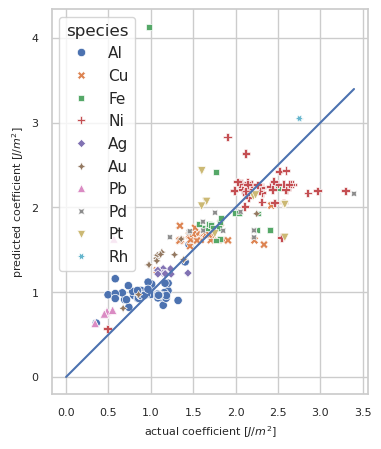

In [17]:
pred_vs_actual_plot(df_data)

# Make predictions from first-principles indicator properties

Now, we will import the DFT data that we will use with our model to make inferred predictions based on the indicator properties. First, get the data.

In [18]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_dft.csv?raw=true"
df_dft = pd.read_csv(url_link, index_col=0)
df_dft.head()

,species,bulk_modulus_fcc,c44_fcc,C11-C12,surface_energy_111_fcc,surface_energy_121_fcc,surface_energy_100_fcc,unstable_stack_energy_fcc,intr_stack_fault_energy_fcc,lattice_constant_fcc,relaxed_formation_potential_energy_fcc,vacancy_migration_energy_fcc,units,dft_exact_coeff
0,Ag,92.8612,41.2075,31.0503,0.044252,0.050806,0.049370,0.006472,0.001067,4.1457,0.7209,0.6564,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.032129
1,Al,76.0248,33.6604,53.4132,0.050868,0.059045,0.058608,0.010430,0.007602,4.0378,0.6413,0.3347,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.886213
2,Au,144.4053,26.5289,20.9309,0.043441,0.050244,0.054176,0.005418,0.001872,4.1539,0.2512,0.3986,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.842135
3,Cu,133.9783,79.5973,53.4236,0.080203,0.092686,0.090315,0.011104,0.002628,3.6239,0.8481,0.6623,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.551010
4,Ni,206.5840,117.5921,83.1221,0.114032,0.140808,0.139810,0.017851,0.008919,3.5036,1.2142,1.0189,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",2.302325


**Task:** Write a function that filters your model performance list from above based on the DFT properties available.

In [19]:
def filter_model_results(df, dft_list):
    """takes in a df of k-fold CV results, and filters based on a list of properties

    Args:
        df (_type_): _description_
        dft_list (_type_): _description_

    Returns:
        _type_: _description_
    """
    results = []
    for i, row in df.iterrows():
        factors = row.factors
        if all(factor in dft_list for factor in factors):
            results.append(row)
    return pd.DataFrame(results)

df_result_dft_only = filter_model_results(df_results, df_dft.columns.to_list())
df_result_dft_only.head()

,factors,num_factors,cv_score,cv_score_std
32,"[c44_fcc, unstable_stack_energy_fcc]",2,-0.264096,0.109616
14,"[lattice_constant_fcc, unstable_stack_energy_fcc]",2,-0.325815,0.064970
17,"[bulk_modulus_fcc, c44_fcc]",2,-0.345743,0.135559
31,"[c44_fcc, intr_stack_fault_energy_fcc]",2,-0.359206,0.119502
11,"[lattice_constant_fcc, c44_fcc]",2,-0.361473,0.105192


**Task:** Make a list that identifies the factors from the top performing model. Using your previously created function `add_pred`, make a prediction from DFT indicator properties and add the results to `df_dft`.

In [20]:
# best model of the 5 available DFT properties
dft_model_properties = ['c44_fcc',  
                        'unstable_stack_energy_fcc'
                       ]

df_dft['dft_pred_coeff'] = add_pred(df_dft, 
                                    pipe,
                                    dft_model_properties,
                                    label="dft_exact_coeff")

Now, use the plotting function provided below to show a boxplot of coefficient results, along with the predicted versus actual DFT coefficient.

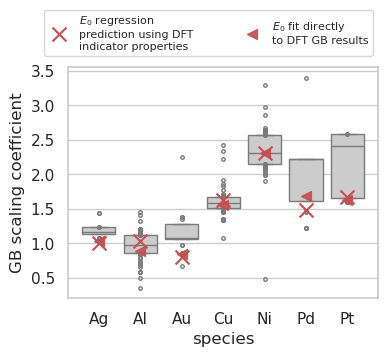

In [21]:
def get_boxplot(df_ip, 
                df_dft, 
                plot_errorbar = True,
                order_list = ["Ag","Al","Au","Cu","Ni","Pd","Pt"]):
    """plot boxplot of dft GB results
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(data = df_ip, 
                x="species", 
                y="coeff", 
                order=order_list, 
                color = "0.8", 
                linewidth=1.0,
                fliersize=5.0,
                whis=0,
                flierprops={"marker":"."},
                zorder=1)
    ax.set_ylabel("GB scaling coefficient")

    # add dft Xs
    ax.scatter(df_dft['species'],
               df_dft['dft_pred_coeff'], 
               marker='x', 
               s=100., 
               alpha=1.0, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ regression prediction using DFT indicator properties",20)),
               zorder=3)

    df_dft_gb_plot = df_dft[['species','dft_exact_coeff']].drop_duplicates()
    df_dft_gb_plot = df_dft_gb_plot[df_dft_gb_plot['species'].isin(order_list)]
    ax.scatter(df_dft_gb_plot['species'],
               df_dft_gb_plot['dft_exact_coeff'], 
               marker='<', 
               s=50., 
               alpha=0.9, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ fit directly to DFT GB results",20)),
               zorder=2)

    # add errorbars if desired
    if plot_errorbar == True:
        ax.errorbar(df_dft['species'],
                    df_dft['regr_coeff'], 
                    yerr = (df_dft['regr_coeff_lower'],
                            df_dft['regr_coeff_upper']), 
                            fmt='.', 
                            markersize=0.0001, 
                            alpha=0.5, 
                            color="r",
                            #label='\n'.join(wrap("Predicted strength using DFT indicator properties",20)),
                            elinewidth=2.0,
                            capsize = 4)

    fig.legend(bbox_to_anchor = (0.05,0.9,0.85,.15),#(0.,1.02,1.,.102),
                    loc='lower left',
                    mode="expand",
                    ncol = 2,
                    fontsize= 8)

    return 

get_boxplot(df_data, df_dft, plot_errorbar=False)

Additional ideas to explore, as time permits:
- Try different combinations of factors, try to find a better model!
- Explore different model types than linear regression: SVR, ensemble of regressors, ...
    - see [here](https://scikit-learn.org/stable/machine_learning_map.html) for ideas
- Repeat with strength data
    - URL link to data: https://github.com/bjasperson/property-covariance-demo/blob/main/data/strength_data.csv?raw=true"